# Defining new similarity targets

In this tutorial we demonstrate how we can define custom similarity target functions. This allows for easily deriving new dimensionality reduction techniques. 

A similarity generator function in the PySEF adheres to the following pattern:

```python
def custom_similarity_function(target_data, target_labels, sigma, idx, 
    target_params):
    Gt = np.zeros((len(idx), len(idx)))
    Gt_mask = np.zeros((len(idx), len(idx)))
    # Calculate the similarity target here
    return np.float32(Gt), np.float32(Gt_mask)
```

Any similarity target function receives 5 arguments: the target data (usually used when we want to mimic another technqiue), the target_labels (usually used when supervised information is availabe), the sigma (scaling factor) that must be used in the similarity calculations, the indices of the current batch and the target_params (used to pass additional arguments to the similarity function). The similarity function must return the similarity **only** for the target_data/labels pointed by the indices (idx). In each iteration a different set of indices are passed to the function (for calculating the target similarity matrix for a different batch). Note that the target_data, target_labels, sigma, and target_params are passed through the *fit* function. A similarity function might not need all these data (*None* can be safely passed to the arguments that are not used).

So, lets define a custom similarity target function that uses supervised information (labels) and sets the target similarity to 0.8 for samples that belong to the same class and 0.1 otherwise.
 

In [3]:
def sim_target_supervised(target_data, target_labels, sigma, idx, target_params):

    cur_labels = target_labels[idx]
    N = cur_labels.shape[0]

    N_labels = len(np.unique(cur_labels))

    Gt, mask = np.zeros((N, N)), np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            if cur_labels[i] == cur_labels[j]:
                Gt[i, j] = 0.8
                mask[i, j] = 1
            else:
                Gt[i, j] = 0.1
                mask[i, j] = 0.8 / (N_labels - 1)

    return np.float32(Gt), np.float32(mask)

Note that we also appropriately set the weighting mask to account for the imbalance between the intra-class and inter-class samples. It is important to remember to work only with the current batch (using the idx) and not with the whole training set (that is always passed to target_data/target_labels). Also, note that the *target_data*, *sigma* and *target_params* arguments are not used.

Load three classes of the MNIST dataset to evaluate the function that we just defined.

In [4]:
import numpy as np
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# We will only use the training data
x_train = np.float32(x_train.reshape((x_train.shape[0], -1)) / 255.0)

# Sample three classes
idx = np.logical_or(y_train == 0, y_train == 1)
idx = np.logical_or(idx, y_train == 2)
x_train, y_train = x_train[idx], y_train[idx]
x_train, y_train = x_train[:100, :], y_train[:100]

Now, learn a kernel projection to achieve the target similarity defined by *sim_target_supervised*:

In [5]:
import sef_dr

proj = sef_dr.KernelSEF(x_train, x_train.shape[0], 2, sigma=1, )
proj.fit(x_train, target_labels=y_train, target=sim_target_supervised, epochs=500, learning_rate=0.0001, regularizer_weight=0, verbose=0)
train_data = proj.transform(x_train)


Note that we pass the *sim_target_supervised* function in the *target* argument and we only define the *target_labels* argument in the *fit()* function. 

Now we can plot the learned projection:

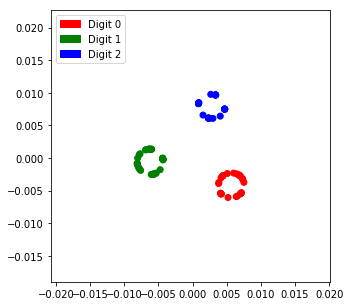

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline  

fig = plt.figure(figsize=(5, 5))
plt.scatter(train_data[:, 0], train_data[:, 1], c=y_train,
            cmap=matplotlib.colors.ListedColormap(['red', 'green', 'blue', ]))
plt.legend(handles=[mpatches.Patch(color='red', label='Digit 0'), mpatches.Patch(color='green', label='Digit 1'),
                        mpatches.Patch(color='blue', label='Digit 2')], loc='upper left')

plt.show()

The target that we defined tries to place the samples of the same class close together (but not to collapse them into the same point), as well as to repel samples of different classes (but it still maintains as small similarity between them). This problem is ill-posed in the 2-D space (when more than 3 points per class are used). The optimization converges to a quite interesting solution: the samples of the same class have been arranged in circles, while the circles of different classes are almost equidistant to each other!